In [1]:
import os, time
from os.path import exists, join
import re
import cv2
import glob
import numpy as np

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
def try_find_path( p ):
    if not exists( p ):
        raise Exception( "%s is not found." % p )

In [3]:
def read_grayscale( p ):
    return cv2.imread( p, cv2.IMREAD_GRAYSCALE )

In [4]:
def show_img( origin_img, tissue_type, old_img, new_img ):
    fig, (a1, a2) = plt.subplots( 1,  2, figsize=(25,25) )
    plt.title(tissue_type)
    a1.imshow(origin_img)
    a1.set_title(tissue_type)
    a2.imshow(new_img, cmap='gray')
    a2.set_title('new')
#     a2.imshow(old_img, cmap='gray')
#     a2.set_title('old')
#     a3.imshow(new_img, cmap='gray')
#     a3.set_title('new')
    fig.show()
    
def show_images(images):
    width, height = 25, 25
    fig           = fig=plt.figure(figsize=(width, height))
    columns       = 2
    rows          = round((len(images) / columns) + 0.5 )
    print("row", rows)
    for i in range(len(images)):
        img_path = images[i]
        img = cv2.imread( img_path, cv2.IMREAD_COLOR )
        img = cv2.cvtColor( img , cv2.COLOR_BGR2RGB )
        f = fig.add_subplot(rows, columns, i+1)
        f.title.set_text('{}:    {}'.format(i, img_path.split(os.sep)[-1]))
        plt.imshow(img)
    plt.show()


In [5]:
def checkDoNothing(image_paths):
    try:
        if not len(image_paths) > 0 or not type(image_paths) == list: return False
        
        img = read_grayscale( image_paths[0] )
        tmp = np.zeros_like(img)
        for image_path in image_paths:
            if '.jpg' in image_path:
                continue
            img = read_grayscale(image_path) 
            img[img > 0] = 1
            
#             uniq, count_uniq = np.unique(img, return_counts=True)
#             print( image_path, '\n', uniq, count_uniq)
            
            tmp += img
        tmp[tmp == 1] = 0
#         uniq, count_uniq = np.unique(tmp, return_counts=True)
#         print( uniq, count_uniq)
        count_no_zero = np.count_nonzero(tmp)
        return True if count_no_zero == 0 else False 
    except Exceptions as e:
        print('error check dup', e)
        return False 
        

In [6]:
def process( selected_dir, dir_name ):
#     Images_Medetec_dir = join( os.getcwd(), dataset_name)
#     try_find_path(Images_Medetec_dir)
    
#     dir_name = input( "dir: " )
#     selected_dir = join( Images_Medetec_dir, dir_name )
    try_find_path( selected_dir )
    
    all_images = glob.glob(selected_dir + "/*.jpg") + glob.glob(selected_dir + "/*.png")
    versions = [ x.split(os.sep)[-1].split('_')[-1].split('.')[0][-3:] for x in all_images if '.png' in x]
    last_version = sorted(set(versions))[-1]
    old_version = [x for x in set(versions) if x != last_version ]
    
    
#     print("last_version: ", last_version)
    images = [x for x in all_images if '.jpg' in x or "{}.png".format(last_version) in x]

    images = sorted(images)
    do_noting = checkDoNothing(images)
    
    print(last_version," -> ", do_noting, " :\t", selected_dir)
    
    if do_noting: 
        return 'next'
    
    remove_olds = []
    for version in old_version:
        for file_type in ['tif', 'png']: 
            remove_olds += glob.glob(selected_dir + "/*{}.{}".format(version, file_type))
   
    print("remove_images", remove_olds)
    for i in remove_olds:
        os.remove(i)
        
    show_images(images)
    
    original_img_name = "%s.jpg" % dir_name
    original_img_path = join( selected_dir , original_img_name )
    try_find_path( original_img_path )

    original_img = cv2.cvtColor( cv2.imread( original_img_path, cv2.IMREAD_COLOR ) , cv2.COLOR_BGR2RGB )
    overlay = original_img.copy() 
    output = original_img.copy()
    
    alpha = 0.2
    step_list = input( "step list: " )
    try:
        step_list = [int(x) for x in step_list]
        print(type(step_list), step_list)
    except:
        if 'n' in step_list:
            return 'next'
        elif 'e' in step_list:
            return 'exit'
        else:
            return 'next'
    
    
    
    result_imgs = []
    merge_tissue = np.zeros((original_img.shape[0], original_img.shape[1]))     
    
    for index, value in enumerate(step_list):
        
        sub_overlay = original_img.copy() 
        sub_output = original_img.copy()
        tissue_type = images[value].split('os.sep')[-1]
    

        
        print('step ', value, tissue_type)
        background_img_path = images[value]
        background_img = read_grayscale( background_img_path )
        new_img = background_img.copy()
        for restValue in step_list[index + 1:]:
            print(restValue)
            foreground_img = read_grayscale( images[restValue] )
            new_img[foreground_img != 0 ] = 0
        
        result_imgs += [[background_img_path, new_img]]    
        print(tissue_type, 'empty' in tissue_type)
        if not 'empty' in tissue_type:
            merge_tissue[new_img > 0] = 1
            
            sub_overlay[new_img > 0] = (98, 255, 46)
            cv2.addWeighted(sub_overlay, alpha, sub_output, 1 - alpha, 0, sub_output)
            show_img(sub_output, tissue_type, background_img, new_img)
            plt.show()
        
    overlay[merge_tissue > 0] = (98, 255, 46)
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    show_img(output, 'merge tissue', merge_tissue, merge_tissue)
    plt.show()
    
    print('Overwrite?\n yes, y, Y to save\n again, a, A to do again\n else to next')
    command = input("(Y / N / A):")

    if command in ["Y", "y", 'yes']:
        for [path, img] in result_imgs:
            cv2.imwrite( path, img )
    elif command in ['a', 'A', 'again']:
        return 'again'
    else:
        return 'next'
#         new_name = input("new name: ") + ".png"
#         new_path = join( selected_dir, new_name )
#         cv2.imwrite( new_path, new_img )


# Loop checker

start process: 1.65625

001  ->  True  :	 G:\New folder\ton_set1\set4\100322
next: 0.125

001  ->  False  :	 G:\New folder\ton_set1\set4\100323
remove_images []
row 3


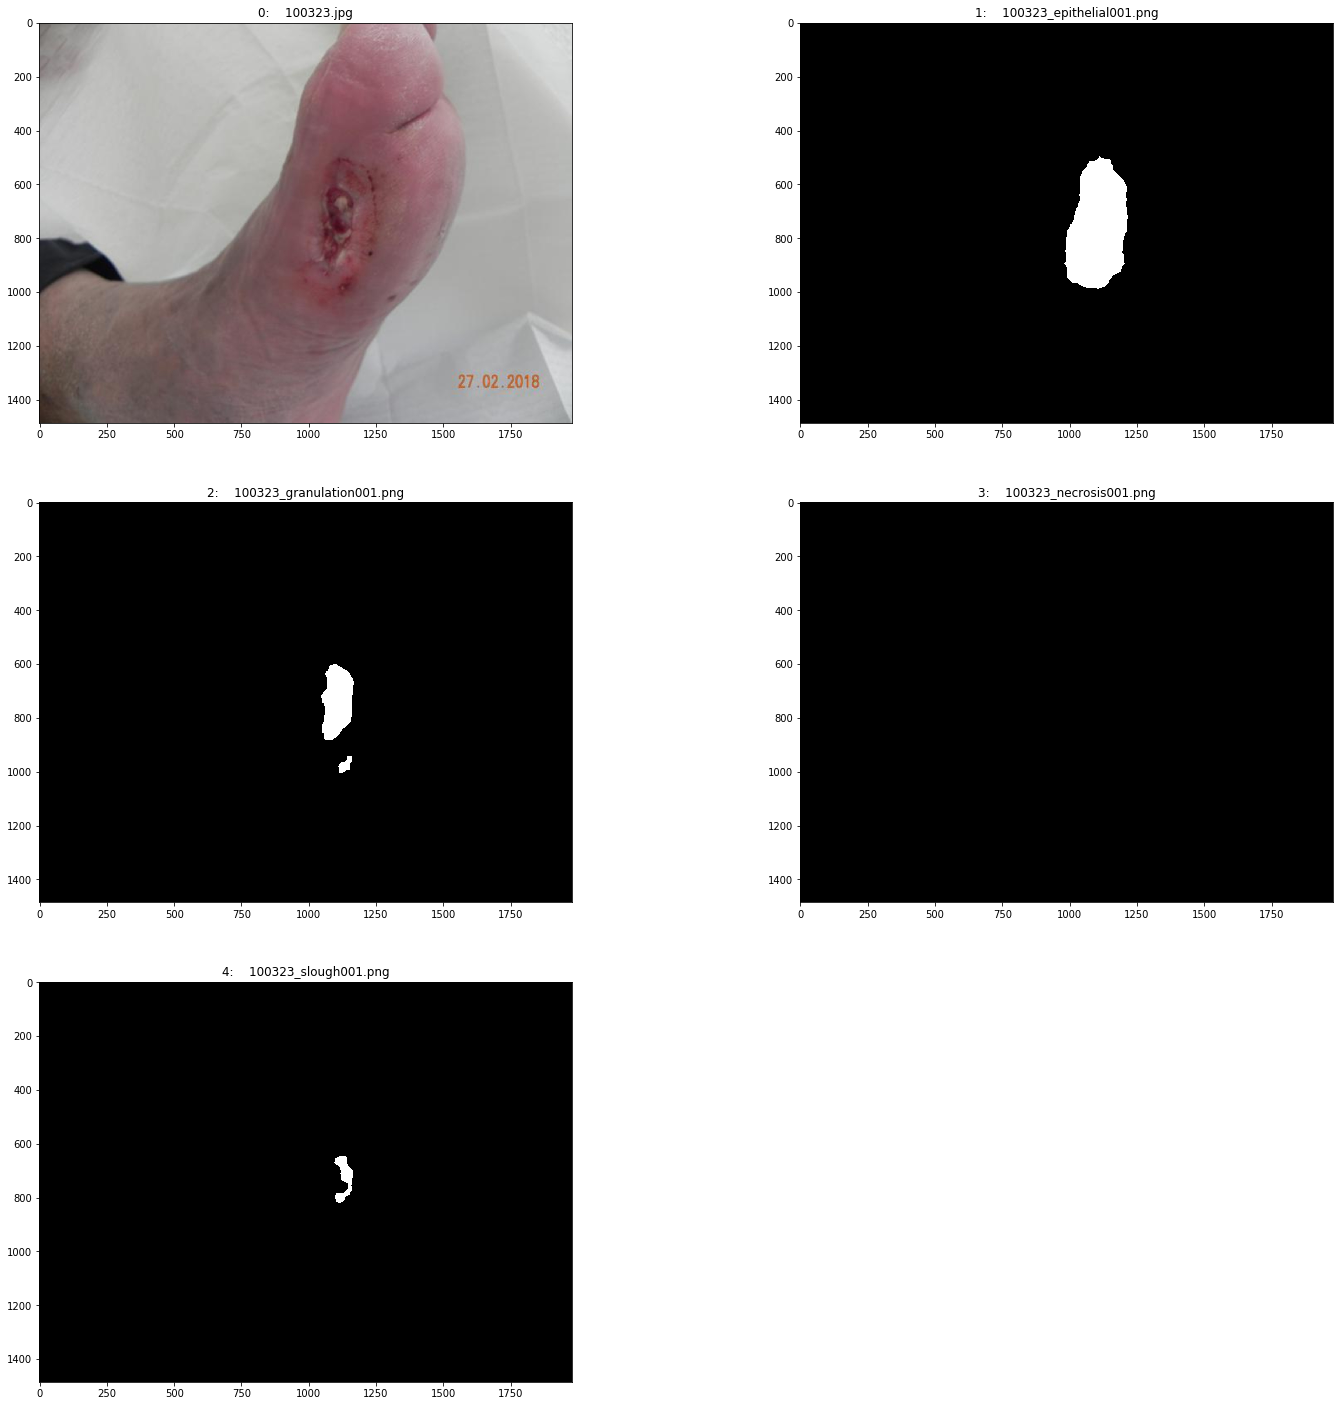

step list: e
exit: 2.34375

END 2.359375


In [8]:
tmp_dir = join( os.getcwd(), 'set4')
start_time = time.process_time()
print('start process: %s\n' %start_time)
for root, dirs, files in os.walk(tmp_dir):
    if(root == tmp_dir):
        dir_index = 0
        while dir_index < len(dirs):
            sub_dir = dirs[dir_index]
            if not sub_dir.isdecimal():
                continue
            full_sub_dir = join(root, sub_dir)
            response = process(full_sub_dir, sub_dir)

            print("{}: {}\n".format(response, time.process_time() - start_time))
            if response == 'next':
                dir_index += 1
            elif response == 'again':
                pass
            elif response == 'exit':
                print('exit')
                break
            
print("END", time.process_time() - start_time)

# Remove empty image

In [ ]:
def clearEmptySpaceImage(image_dir):
    try:
        emptry_paths = glob.glob(join(image_dir, '*empty*'))
        for empty_space_path in emptry_paths:
            os.remove(empty_space_path)
        return True, [x.split(os.sep)[-2] for x in emptry_paths]
    except Exception as e:
        print('error', e)
        return False, []

try_find_path(tmp_dir)
print(tmp_dir)

for root, dirs, files in os.walk(tmp_dir):
    if(root == tmp_dir):
        for sub_dir in dirs:
            if not sub_dir.isdecimal():
                continue
            full_sub_dir = join(root, sub_dir)
            status, files = clearEmptySpaceImage(full_sub_dir)
            if status and len(files) > 0:
                print("{}\t{}".format(sub_dir, ", ".join(files)))

# Check file in dir

In [ ]:
for root, dirs, files in os.walk(tmp_dir):
#     if(root == tmp_dir):
#         for sub_dir in dirs:
#             if not sub_dir.isdecimal():
#                 pass
#             full_sub_dir = join(root, sub_dir)
#             print("root", full_sub_dir)
#             for i in glob.glob(join(full_sub_dir, '*.png')):
#                 print("\t{}".format(i.split(os.sep)[-1]))
    print("{}\n\t{}".format(root, '\n\t'.join(sorted(set([ "{1}".format(i, re.sub('[0-9]*', '', k)) for i, k in enumerate([x.split("_")[-1].split('.')[0] for x in files]) if not k.isdecimal()])))))